# Istanbul Stock Exchange Data Experiment 
Semi-synthetic dataset experiment

<strong>Note</strong>: This notebook yields the most stable results out of any of the notebooks submitted.

In [1]:
import sys 
sys.path.append('../..')
import cox
from cox.store import Store
from cox.utils import Parameters
from cox.readers import CollectionReader
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import math
from sklearn.metrics import r2_score
import os
import datetime

from delphi import oracle 
from delphi.stats.linear_regression import TruncatedRegression

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

TABLE_NAME = 'logs'

# Import Istanbul Stock Exchange Dataset into Notebook
You need to download the [ISTANBUL STOCK EXCHANGE](https://archive.ics.uci.edu/ml/datasets/ISTANBUL+STOCK+EXCHANGE) dataset from the UCI dataset repository.

In [2]:
ISTANBUL_DATASET_PATH = '/Users/patroklos/Desktop/research/data_akbilgic.xlsx'
ist_df = pd.read_excel(ISTANBUL_DATASET_PATH, engine='openpyxl', skiprows=[0])
ist_df.head()

/opt/anaconda3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:296: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,date,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,2009-01-05,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,2009-01-06,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,2009-01-07,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,2009-01-08,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,2009-01-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


# Data Exploration

# Create Correlation Matrix
Create a correlation matrix to see which indices' performances are closely correlated with one another.

In [3]:
indices = ist_df.drop(['date'], axis=1)
corr_matrix = indices.corr()
corr_matrix

,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
ISE,1.000000,0.942897,0.439489,0.602081,0.622948,0.260052,0.432898,0.655519,0.600295
ISE.1,0.942897,1.000000,0.449561,0.629218,0.648740,0.393225,0.446889,0.690761,0.701954
SP,0.439489,0.449561,1.000000,0.685843,0.657673,0.131250,0.722069,0.687550,0.528243
DAX,0.602081,0.629218,0.685843,1.000000,0.867369,0.258538,0.585791,0.936393,0.665162
FTSE,0.622948,0.648740,0.657673,0.867369,1.000000,0.255236,0.596287,0.948963,0.687543
NIKKEI,0.260052,0.393225,0.131250,0.258538,0.255236,1.000000,0.172752,0.283750,0.547288
BOVESPA,0.432898,0.446889,0.722069,0.585791,0.596287,0.172752,1.000000,0.621704,0.688074
EU,0.655519,0.690761,0.687550,0.936393,0.948963,0.283750,0.621704,1.000000,0.716502
EM,0.600295,0.701954,0.528243,0.665162,0.687543,0.547288,0.688074,0.716502,1.000000


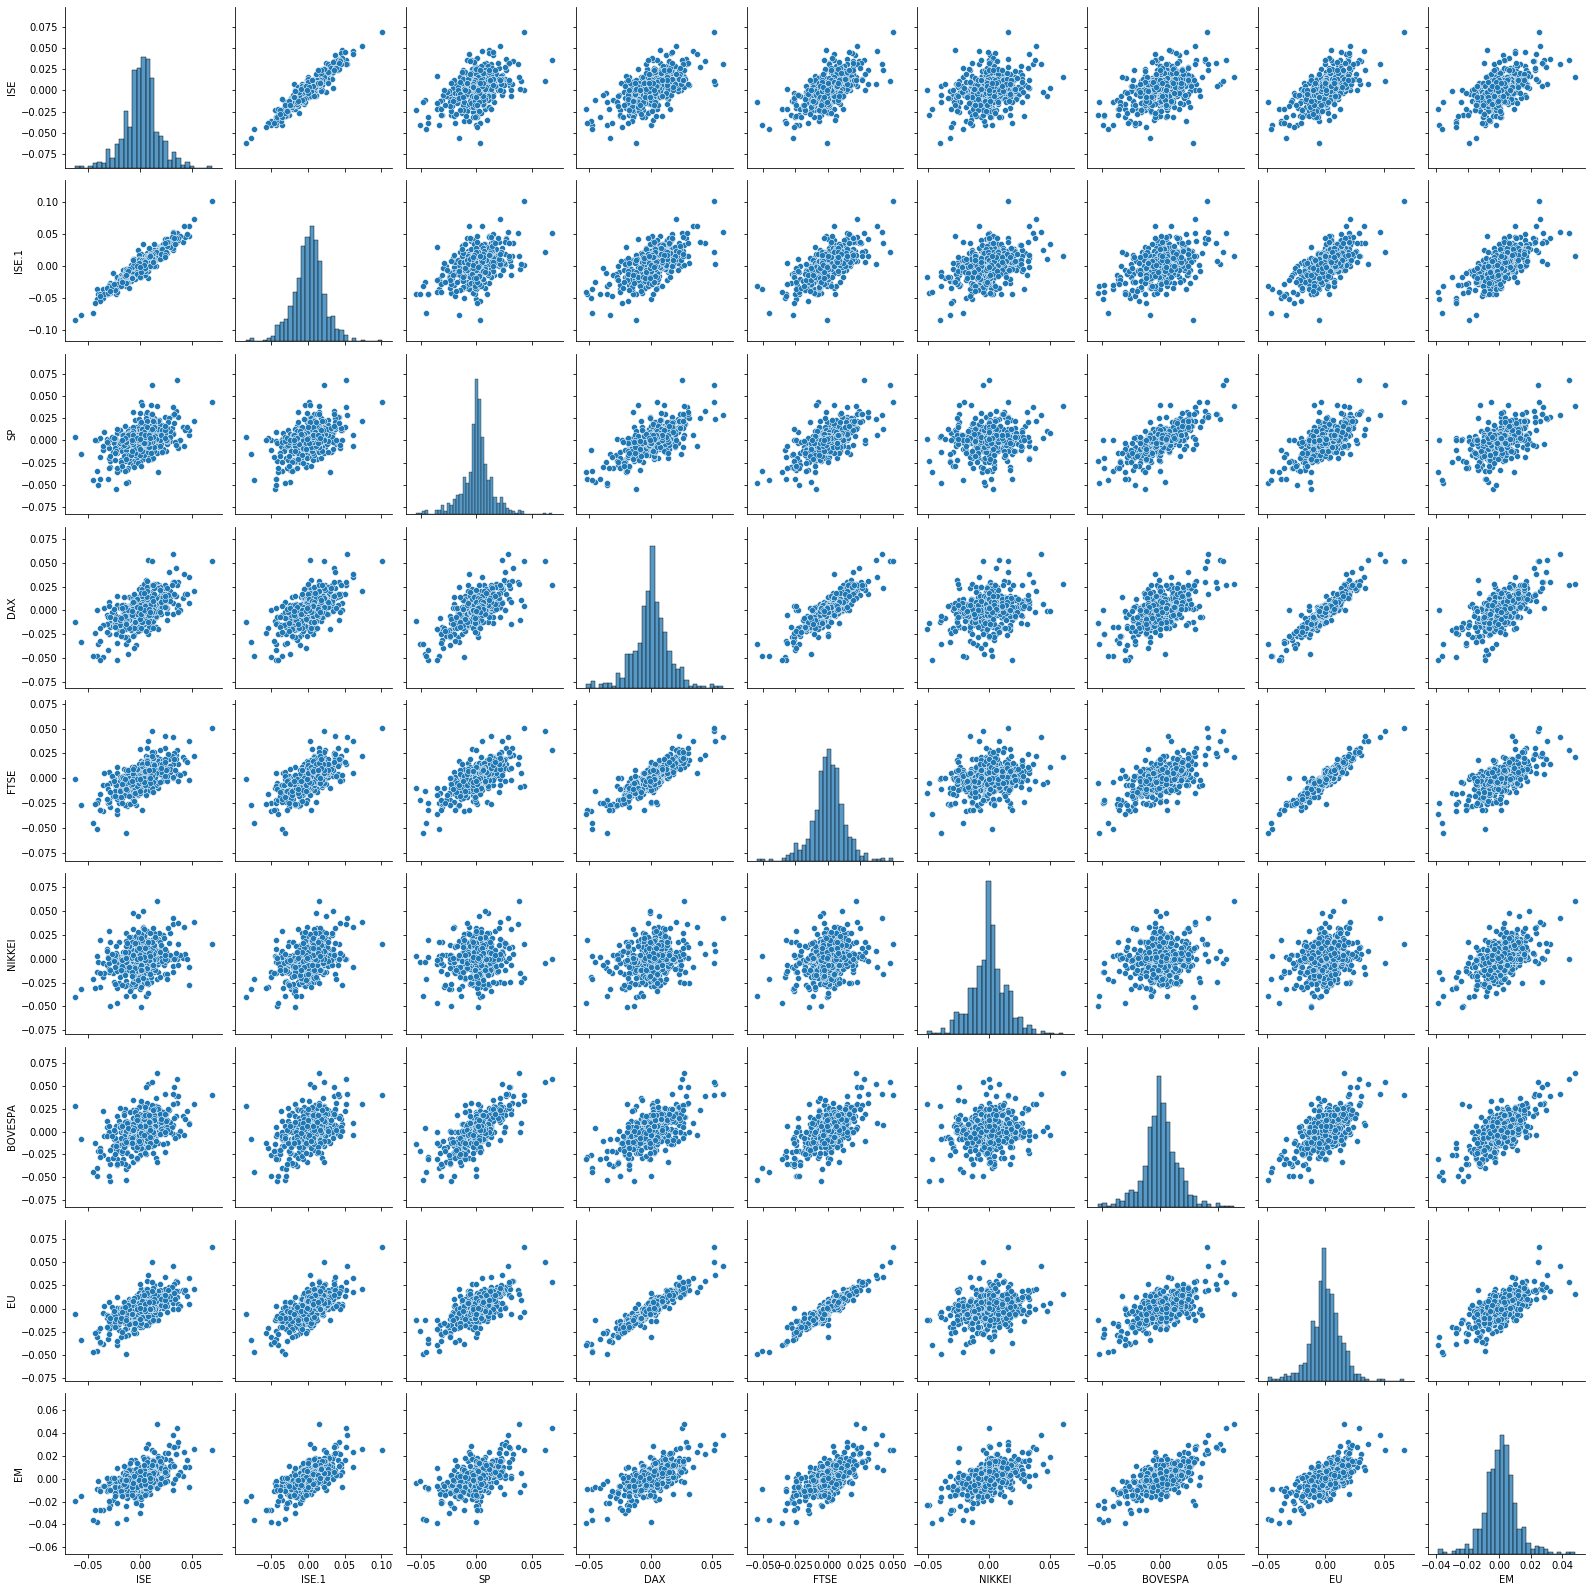

In [31]:
sns.pairplot(ist_df)

When looking at the dataset, we can see that the EU index is highly correlated with the FTSE index. 

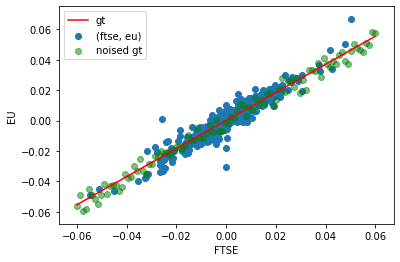

ground-truth variance:  1.7176722394651733e-05


In [4]:
unstacked_corr = corr_matrix.unstack()
unstacked_corr['EU']
eu, ftse = Tensor(ist_df['EU'].to_numpy())[...,None], Tensor(ist_df['FTSE'].to_numpy())[...,None]
data = ch.linspace(-.06, .06, 100).reshape(100, 1)

ols = LinearRegression()
ols.fit(eu, ftse)
gt_var = (eu - ols.predict(ftse)).var(0)

ax = plt.subplot(1, 1, 1)
plt.plot(data, ols.predict(data), color='r', label='gt')
plt.scatter(ftse, eu, label='(ftse, eu)')
plt.scatter(data, Tensor(ols.predict(data)) + ch.sqrt(gt_var)*ch.randn(data.shape[0], 1), color='g', alpha = .5, label='noised gt')
ax.set_xlabel('FTSE')
ax.set_ylabel('EU')
plt.legend()
plt.show()

print('ground-truth variance: ', float(gt_var))

# Truncate Regression


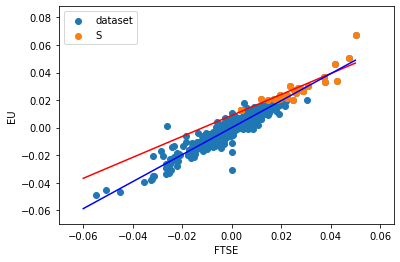

In [30]:
phi = oracle.Left(0.02)
indices = phi(eu).nonzero(as_tuple=False).flatten()

eu_trunc, ftse_trunc = eu[indices], ftse[indices]
trunc_ols = LinearRegression()
trunc_ols.fit(ftse_trunc, eu_trunc)
data = ch.linspace(-.06, .05, 100)[...,None]

ax = plt.subplot(1, 1, 1)
plt.scatter(ftse, eu, label='dataset')
plt.scatter(ftse_trunc, eu_trunc, label='S')
plt.plot(data, trunc_ols.predict(data), color='red')
plt.plot(data, ols.predict(data), color='blue')
ax.set_xlabel('FTSE')
ax.set_ylabel('EU')
plt.legend()
plt.show()

(array([ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  4.,  1.,  0.,  1.,  1.,
         3.,  3.,  5.,  3.,  1.,  4.,  2.,  1.,  2.,  4.,  5.,  5.,  6.,
         6.,  6.,  9., 16.,  8.,  9., 14., 18., 17., 24., 22., 18., 23.,
        36., 19., 16., 22., 22., 13., 25., 17., 24.,  9.,  7., 10.,  4.,
        10.,  8.,  7.,  3.,  5.,  8.,  2.,  5.,  3.,  1.,  1.,  2.,  1.,
         1.,  2.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([-0.05481596, -0.05376457, -0.05271319, -0.0516618 , -0.05061041,
        -0.04955903, -0.04850764, -0.04745625, -0.04640487, -0.04535348,
        -0.04430209, -0.04325071, -0.04219932, -0.04114794, -0.04009655,
        -0.03904516, -0.03799377, -0.03694239, -0.035891  , -0.03483962,
        -0.03378823, -0.03273684, -0.03168546, -0.03063407, -0.02958268,
        -0.0285313 , -0.02747991, -0.02642852, -0.02537714, -0.024325

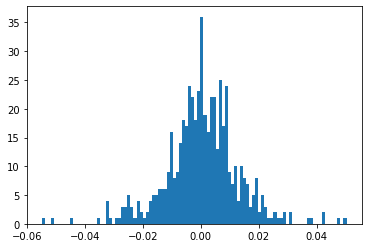

In [33]:
plt.hist(ftse.T, bins=100)

In [ ]:
phi = oracle.Right(100)
indices = phi(y).flatten().nonzero(as_tuple=False).flatten()
x_trunc, y_trunc = X[indices], y[indices]
alpha = x_trunc.size(0) / X.size(0)
print("alpha: ", alpha)

# Data Preprocessing
Select the performance results for the EM and EU indices. Since, the performance results are expressed in decimals (because they are percentages) and are extremely small, we standardize the data, so that are gradients aren't negatively influenced by the magnitude of the performance rates.

emp noise var:  tensor([1.9172e-05])


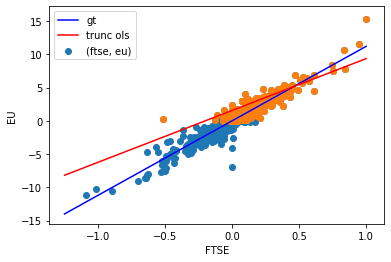

In [7]:
# scale dependent variable by sigma
emp_noise_var = (eu_trunc - trunc_ols.predict(ftse_trunc)).var(0)
print("emp noise var: ", emp_noise_var)

eu_trunc_emp_scaled = eu_trunc / ch.sqrt(emp_noise_var)
beta = LA.norm(ftse_trunc, dim=-1, ord=float('inf')).max()
ftse_trunc_norm = ftse_trunc / beta
ftse_norm = ftse / beta
eu_emp_scaled = eu / ch.sqrt(emp_noise_var)

emp_scaled_ols = LinearRegression()
emp_scaled_ols.fit(ftse_norm, eu_emp_scaled)

trunc_emp_scaled_ols = LinearRegression()
trunc_emp_scaled_ols.fit(ftse_trunc_norm, eu_trunc_emp_scaled)

data = np.linspace(-1.25, 1, 100).reshape(-1, 1)
ax = plt.subplot(1, 1, 1)
plt.scatter(ftse_norm, eu_emp_scaled, label='(ftse, eu)')
plt.scatter(ftse_trunc_norm, eu_trunc_emp_scaled)
plt.plot(data, emp_scaled_ols.predict(data), color='b', label='gt')
plt.plot(data, trunc_emp_scaled_ols.predict(data), color='r', label='trunc ols')
ax.set_xlabel('FTSE')
ax.set_ylabel('EU')
plt.legend()
plt.show()

# Set up Experiment
For storing the experiment's hyperparameters, we use [cox](https://github.com/MadryLab/cox), MadryLab's light-weight experimental design and analysis framework. 

In [14]:
args = Parameters({
    "bias": True,
    "bs": 10,
    "trials": 100,
    "steps": 2500,
    "out_dir": '/Users/patroklos/regression/', 
    "table_name": 'results', 
    'tol': 1e-2,
    'n': 100,
})
EXP = 'Istanbul'
mse_loss = ch.nn.MSELoss()

# Create Store for Experiment Results

In [15]:
def run_trial(kwargs, X, y):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > 3e-1) and attempt < 3:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time  

# Run Procedure

In [16]:
# ground_truth parameters
gt = LinearRegression() 
gt.fit(ftse, eu)
gt_params = Tensor(np.concatenate([gt.coef_, np.expand_dims(gt.intercept_, 0)], axis=1))
gt_var = Tensor(np.var(gt.predict(ftse) - eu.numpy(), 0))

C = [-.05, -.04, -.03, -.02, -.01, 0, .01, .02, .03]
for i in range(args.trials):
    # create store
    store = Store(args.out_dir + EXP)
    store.add_table(TABLE_NAME, { 
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_r2': float,
        'unknown_time': int,
        'ols_r2': float, 
        'ols_param_mse': float,
        'ols_var_l1': float,
#         'trunc_reg_param_mse': float, 
#         'trunc_var_l1': float,
        'alpha': float, 
        'c': float, 
        'num_samples': int,
    })
    
    for c in C: 
        # truncate
        phi = oracle.Left(c)
        indices = phi(eu).eq(1).flatten()
        x_trunc, y_trunc = ftse[indices], eu[indices].float()
        # add survival probability to hyperparameters
        alpha = Tensor([x_trunc.shape[0] / ftse.shape[0]])
        print("alpha: ", alpha)
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        emp_noise_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[...,None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        
        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(eu.flatten(), ols.predict(ftse).flatten()), 
            'ols_var_l1': ch.abs(emp_noise_var - gt_var),
            'ols_param_mse': mse_loss(ols_params, gt_params.flatten()),
        })
        
        val = int(.1*x_trunc.size(0))
        
        beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
        x_trunc_norm = x_trunc / beta
        
        # scale by the known noise variance 
        y_trunc_scaled = y_trunc / ch.sqrt(gt_var)
        phi_scaled = oracle.Left(phi.left / ch.sqrt(gt_var))
        
        # standardize noised by actual noise variance
        known_kwargs = { 
            'phi': phi_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        # truncated linear regression with known noise variance using empirical noise variance
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, y_trunc_scaled) 
        
        with ch.no_grad():       
            w, w0 = (known_trunc_reg.weight * ch.sqrt(gt_var)) / beta, known_trunc_reg.intercept * ch.sqrt(gt_var) 
            known_params = ch.cat([w.flatten(), w0])
            # known results
            store[TABLE_NAME].update_row({
                'known_r2': r2_score(eu.flatten(), ftse@w + w0), 
                'known_param_mse': mse_loss(known_params, gt_params.flatten()),
                'known_time': total_time, 
            })
            
        
        phi_emp_scaled = oracle.Left(phi.left / ch.sqrt(emp_noise_var))
        y_trunc_emp_scaled = y_trunc / ch.sqrt(emp_noise_var)
            
        # standardize noised by actual noise variance
        unknown_kwargs = { 
            'phi': phi_emp_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        # truncated linear regression with unknown noise variance using empirical noise variance
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, y_trunc_emp_scaled)  
        
        with ch.no_grad():      
            w, w0 = (unknown_trunc_reg.weight * unknown_trunc_reg.variance * ch.sqrt(emp_noise_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var) * unknown_trunc_reg.variance 
            unknown_params = ch.cat([w, w0]).flatten()
            # known results
            store[TABLE_NAME].update_row({
                'unknown_r2': r2_score(eu.flatten(), ftse@w + w0), 
                'unknown_param_mse': mse_loss(unknown_params, gt_params.flatten()),
                'unknown_time': total_time, 
                'unknown_var_l1': ch.abs(unknown_trunc_reg.variance * emp_noise_var - gt_var)
            })
            

        store[TABLE_NAME].append_row({ 
            'alpha': float(alpha), 
            'c': c,    
            'num_samples': x_trunc.size(0),
        })
            
    # close current store
    store.close()

Logging in: /Users/patroklos/regression/Istanbul/d235477f-e6b1-4734-acd6-91c4b790600c
alpha:  tensor([1.])
Iteration 1 | Score: 0.07004668563604355
Iteration 2 | Score: 0.061846934258937836
Iteration 3 | Score: 0.059765592217445374
Final Score: 0.001202637329697609
Iteration 1 | Score: 1.9148584604263306
Iteration 2 | Score: 0.08691680431365967
Iteration 3 | Score: 0.59805828332901
Iteration 4 | Score: 0.2803637385368347
Iteration 5 | Score: 0.26411962509155273
Iteration 6 | Score: 0.16391074657440186
Iteration 7 | Score: 0.30217549204826355
Iteration 8 | Score: 1.3301410675048828
Iteration 9 | Score: 0.1357138305902481
Iteration 10 | Score: 0.6145946383476257
Iteration 11 | Score: 0.32807591557502747
Iteration 12 | Score: 0.1769794523715973
Iteration 13 | Score: 0.19502519071102142
Iteration 14 | Score: 0.9977967739105225
Iteration 15 | Score: 1.8703267574310303
Iteration 16 | Score: 0.7651939988136292
Iteration 17 | Score: 0.24782468378543854
Iteration 18 | Score: 0.2026437371969223


Iteration 17 | Score: 1.818743348121643
Iteration 18 | Score: 0.3901936113834381
Iteration 19 | Score: 0.7072185277938843
Iteration 20 | Score: 1.463281512260437
Iteration 21 | Score: 3.130777597427368
Iteration 22 | Score: 2.1690571308135986
Iteration 23 | Score: 0.8567452430725098
Iteration 24 | Score: 0.13906969130039215
Iteration 25 | Score: 1.7177637815475464
alpha:  tensor([0.9440])
Iteration 1 | Score: 0.0427083782851696
Final Score: 0.004361391067504883
Iteration 1 | Score: 0.4580489695072174
Iteration 2 | Score: 1.5160982608795166
Iteration 3 | Score: 0.4089661240577698
Iteration 4 | Score: 0.5442970395088196
Iteration 5 | Score: 0.07456058263778687
Iteration 6 | Score: 0.5164813995361328
Iteration 7 | Score: 0.8897241950035095
Iteration 8 | Score: 1.250789999961853
Iteration 9 | Score: 0.6103163361549377
Iteration 10 | Score: 1.0487009286880493
Iteration 11 | Score: 0.37073758244514465
Iteration 12 | Score: 0.6280728578567505
Iteration 13 | Score: 0.6802928447723389
Iteration

Iteration 17 | Score: 5.122180461883545
Iteration 18 | Score: 4.979666709899902
Iteration 19 | Score: 4.887365818023682
Iteration 20 | Score: 4.965446472167969
Iteration 21 | Score: 5.151971340179443
Iteration 22 | Score: 5.125924110412598
Iteration 23 | Score: 4.959126949310303
Iteration 24 | Score: 5.062611103057861
Iteration 25 | Score: 5.046310901641846
Iteration 1 | Score: 3.0436642169952393
Iteration 2 | Score: 3.1232898235321045
Iteration 3 | Score: 1.3458101749420166
Iteration 4 | Score: 4.393707752227783
Iteration 5 | Score: 4.393707752227783
Iteration 6 | Score: 4.393707752227783
Iteration 7 | Score: 4.393707752227783
Iteration 8 | Score: 4.393707752227783
Iteration 9 | Score: 4.393707752227783
Iteration 10 | Score: 4.393707752227783
Iteration 11 | Score: 4.393707752227783
Iteration 12 | Score: 4.393707752227783
Iteration 13 | Score: 4.393707752227783
Iteration 14 | Score: 4.393707752227783
Iteration 15 | Score: 4.393707752227783
Iteration 16 | Score: 4.393707752227783
Iterat

Iteration 17 | Score: 13.371935844421387
Iteration 18 | Score: 5.713678359985352
Iteration 19 | Score: 13.371935844421387
Iteration 20 | Score: 3.480926752090454
Iteration 21 | Score: 114.15689849853516
Iteration 22 | Score: 53.56135940551758
Iteration 23 | Score: 0.27382853627204895
Iteration 24 | Score: 472.20416259765625
Iteration 25 | Score: 2.902941942214966
alpha:  tensor([0.0112])
Logging in: /Users/patroklos/regression/Istanbul/fd265406-274e-4072-ac62-4a7bda3295ba
alpha:  tensor([1.])
Iteration 1 | Score: 0.06168253719806671
Iteration 2 | Score: 0.08883330971002579
Iteration 3 | Score: 0.06740252673625946
Iteration 4 | Score: 0.07244009524583817
Iteration 5 | Score: 0.08008594810962677
Iteration 6 | Score: 0.12465323507785797
Iteration 7 | Score: 0.06341943144798279
Iteration 8 | Score: 0.07965436577796936
Iteration 9 | Score: 0.1263340413570404
Iteration 10 | Score: 0.10883041471242905
Iteration 11 | Score: 0.1286575049161911
Iteration 12 | Score: 0.14363010227680206
Iteration

Iteration 12 | Score: 0.17387212812900543
Iteration 13 | Score: 0.21598726511001587
Iteration 14 | Score: 0.22951513528823853
Iteration 15 | Score: 0.24155288934707642
Iteration 16 | Score: 0.24809372425079346
Iteration 17 | Score: 0.24855099618434906
Iteration 18 | Score: 0.21293967962265015
Iteration 19 | Score: 0.19729211926460266
Iteration 20 | Score: 0.2440163791179657
Iteration 21 | Score: 0.22255194187164307
Iteration 22 | Score: 0.21985939145088196
Iteration 23 | Score: 0.21395793557167053
Iteration 24 | Score: 0.22365131974220276
Iteration 25 | Score: 0.1867925375699997
Iteration 1 | Score: 0.3865295946598053
Iteration 2 | Score: 1.592128872871399
Iteration 3 | Score: 0.3693111836910248
Iteration 4 | Score: 0.5497799515724182
Iteration 5 | Score: 0.49128103256225586
Iteration 6 | Score: 1.2344821691513062
Iteration 7 | Score: 0.563044548034668
Iteration 8 | Score: 0.4622991979122162
Iteration 9 | Score: 0.4360731244087219
Iteration 10 | Score: 0.43551525473594666
Iteration 11 

Iteration 10 | Score: 0.3817731738090515
Iteration 11 | Score: 0.24393242597579956
Iteration 12 | Score: 0.9335538744926453
Iteration 13 | Score: 0.08924981206655502
Iteration 14 | Score: 0.8376820683479309
Iteration 15 | Score: 0.21968795359134674
Iteration 16 | Score: 1.1821143627166748
Iteration 17 | Score: 0.10286306589841843
Iteration 18 | Score: 0.8257500529289246
Iteration 19 | Score: 2.8155508041381836
Iteration 20 | Score: 0.5726419687271118
Iteration 21 | Score: 0.3253002166748047
Iteration 22 | Score: 0.1323791742324829
Iteration 23 | Score: 0.8431764245033264
Iteration 24 | Score: 0.3872363269329071
Iteration 25 | Score: 0.2481449842453003
Iteration 1 | Score: 0.21373328566551208
Iteration 2 | Score: 0.45914751291275024
Iteration 3 | Score: 0.1644657403230667
Iteration 4 | Score: 0.647957444190979
Iteration 5 | Score: 0.13171091675758362
Iteration 6 | Score: 0.45177412033081055
Iteration 7 | Score: 0.3134605884552002
Iteration 8 | Score: 0.16175542771816254
Iteration 9 | Sc

Iteration 10 | Score: 9.824999809265137
Iteration 11 | Score: 9.145384788513184
Iteration 12 | Score: 9.019033432006836
Iteration 13 | Score: 8.463245391845703
Iteration 14 | Score: 7.770902156829834
Iteration 15 | Score: 7.523288726806641
Iteration 16 | Score: 7.280528545379639
Iteration 17 | Score: 7.662818908691406
Iteration 18 | Score: 7.475709438323975
Iteration 19 | Score: 7.641470432281494
Iteration 20 | Score: 7.555890083312988
Iteration 21 | Score: 7.928001403808594
Iteration 22 | Score: 7.551122188568115
Iteration 23 | Score: 7.470348358154297
Iteration 24 | Score: 7.28651762008667
Iteration 25 | Score: 7.250969409942627
Iteration 1 | Score: 16.88705062866211
Iteration 2 | Score: 16.88705062866211
Iteration 3 | Score: 16.88705062866211
Iteration 4 | Score: 16.88705062866211
Iteration 5 | Score: 16.88705062866211
Iteration 6 | Score: 16.88705062866211
Iteration 7 | Score: 16.88705062866211
Iteration 8 | Score: 16.88705062866211
Iteration 9 | Score: 504.3853454589844
Iteration 

Iteration 5 | Score: 0.27033019065856934
Iteration 6 | Score: 0.16358059644699097
Iteration 7 | Score: 1.4293657541275024
Iteration 8 | Score: 1.3631834983825684
Iteration 9 | Score: 0.564027726650238
Iteration 10 | Score: 1.1494255065917969
Iteration 11 | Score: 0.36146000027656555
Iteration 12 | Score: 0.27184000611305237
Iteration 13 | Score: 1.0108132362365723
Iteration 14 | Score: 1.0399436950683594
Iteration 15 | Score: 0.6801141500473022
Iteration 16 | Score: 1.6806650161743164
Iteration 17 | Score: 0.19289736449718475
Iteration 18 | Score: 0.3192664384841919
Iteration 19 | Score: 1.467764139175415
Iteration 20 | Score: 1.3575688600540161
Iteration 21 | Score: 0.4668486714363098
Iteration 22 | Score: 1.0534166097640991
Iteration 23 | Score: 0.34284839034080505
Iteration 24 | Score: 0.42572736740112305
Iteration 25 | Score: 0.9119695425033569
Iteration 1 | Score: 0.16111980378627777
Iteration 2 | Score: 0.17727647721767426
Iteration 3 | Score: 0.8599467277526855
Iteration 4 | Sco

Iteration 4 | Score: 1.2987377643585205
Iteration 5 | Score: 1.4786622524261475
Iteration 6 | Score: 1.4067440032958984
Iteration 7 | Score: 1.4239747524261475
Iteration 8 | Score: 0.2515934705734253
Iteration 9 | Score: 1.1375352144241333
Iteration 10 | Score: 1.7118762731552124
Iteration 11 | Score: 1.6464005708694458
Iteration 12 | Score: 0.981295108795166
Iteration 13 | Score: 1.2239794731140137
Iteration 14 | Score: 0.4044146239757538
Iteration 15 | Score: 0.5176836252212524
Iteration 16 | Score: 1.2110882997512817
Iteration 17 | Score: 1.5022367238998413
Iteration 18 | Score: 0.7372739911079407
Iteration 19 | Score: 1.407856822013855
Iteration 20 | Score: 0.5688097476959229
Iteration 21 | Score: 0.5685527324676514
Iteration 22 | Score: 1.2427722215652466
Iteration 23 | Score: 1.1844083070755005
Iteration 24 | Score: 0.8239719867706299
Iteration 25 | Score: 1.8524848222732544
Iteration 1 | Score: 0.14407460391521454
Iteration 2 | Score: 0.699927031993866
Iteration 3 | Score: 5.852

Iteration 7 | Score: 0.48446282744407654
Iteration 8 | Score: 0.5260440707206726
Iteration 9 | Score: 0.5842423439025879
Iteration 10 | Score: 0.5011627674102783
Iteration 11 | Score: 0.5763041973114014
Iteration 12 | Score: 0.5332343578338623
Iteration 13 | Score: 0.5398989915847778
Iteration 14 | Score: 0.5660494565963745
Iteration 15 | Score: 0.5321468710899353
Iteration 16 | Score: 0.527894139289856
Iteration 17 | Score: 0.509283185005188
Iteration 18 | Score: 0.5344716906547546
Iteration 19 | Score: 0.5194216966629028
Iteration 20 | Score: 0.49199819564819336
Iteration 21 | Score: 0.5095601677894592
Iteration 22 | Score: 0.5490155816078186
Iteration 23 | Score: 0.5104466080665588
Iteration 24 | Score: 0.5126648545265198
Iteration 25 | Score: 0.5236546397209167
Iteration 1 | Score: 0.3029567003250122
Iteration 2 | Score: 0.27219921350479126
Iteration 3 | Score: 0.2538253664970398
Iteration 4 | Score: 0.2188379317522049
Iteration 5 | Score: 0.1632993519306183
Iteration 6 | Score: 0.

Iteration 11 | Score: 38.40774154663086
Iteration 12 | Score: 34.200984954833984
Iteration 13 | Score: 7.990839004516602
Iteration 14 | Score: 40.22492980957031
Iteration 15 | Score: 38.454044342041016
Iteration 16 | Score: 8.544147491455078
Iteration 17 | Score: 41.227378845214844
Iteration 18 | Score: 5996.4248046875
Iteration 19 | Score: 3.5386738777160645
Iteration 20 | Score: 41.49299240112305
Iteration 21 | Score: 32.50640869140625
Iteration 22 | Score: 3.949775457382202
Iteration 23 | Score: 38.90211868286133
Iteration 24 | Score: 32.24423599243164
Iteration 25 | Score: 9.331201553344727
Iteration 1 | Score: 10.615668296813965
Iteration 2 | Score: 10.615668296813965
Iteration 3 | Score: 10.615668296813965
Iteration 4 | Score: 10.615668296813965
Iteration 5 | Score: 2.9000747203826904
Iteration 6 | Score: 10.615668296813965
Iteration 7 | Score: 10.615668296813965
Iteration 8 | Score: 10.615668296813965
Iteration 9 | Score: 450.1110534667969
Iteration 10 | Score: 10.61566829681396

KeyboardInterrupt: 

# Results

In [18]:
reader = CollectionReader(args.out_dir + EXP)
results = reader.df(TABLE_NAME)
results.head()

100%|██████████| 3/3 [00:00<00:00, 105.23it/s]


,known_r2,known_param_mse,known_time,unknown_param_mse,unknown_var_l1,unknown_r2,unknown_time,ols_r2,ols_param_mse,ols_var_l1,alpha,c,num_samples,exp_id
0,0.900464,2.743253e-05,0,0.035642,0.000005,0.832810,1,0.900531,0.000000,3.131208e-08,1.000000,-0.05,536,62d0ecbb-b6e9-46cd-890b-7be20ffc2274
1,0.900509,1.149221e-05,0,0.076337,0.000007,0.755401,5,0.900509,0.000011,3.462264e-08,0.994403,-0.04,533,62d0ecbb-b6e9-46cd-890b-7be20ffc2274
2,0.900216,7.065413e-05,1,0.086383,0.000008,0.736152,5,0.900136,0.000137,2.135691e-06,0.977612,-0.03,524,62d0ecbb-b6e9-46cd-890b-7be20ffc2274
3,0.899375,4.004112e-07,1,0.037923,0.000006,0.828426,5,0.899636,0.000318,2.291896e-06,0.944030,-0.02,506,62d0ecbb-b6e9-46cd-890b-7be20ffc2274
4,0.896730,1.277092e-03,1,0.069428,0.000009,0.768686,1,0.896738,0.000950,4.175437e-06,0.830224,-0.01,445,62d0ecbb-b6e9-46cd-890b-7be20ffc2274


In [19]:
results[results['c'] == 0.01]

,known_r2,known_param_mse,known_time,unknown_param_mse,unknown_var_l1,unknown_r2,unknown_time,ols_r2,ols_param_mse,ols_var_l1,alpha,c,num_samples,exp_id
6,0.898639,0.000126,2,0.405718,0.000009,-0.076403,5,0.820404,0.005838,0.000002,0.195896,0.01,105,62d0ecbb-b6e9-46cd-890b-7be20ffc2274
6,0.893377,0.001102,1,0.221141,0.000007,-1.546697,5,0.820404,0.005838,0.000002,0.195896,0.01,105,fd265406-274e-4072-ac62-4a7bda3295ba
6,0.897032,0.000703,3,0.000448,0.000001,0.859783,1,0.820404,0.005838,0.000002,0.195896,0.01,105,d235477f-e6b1-4734-acd6-91c4b790600c


# Plot Results

In [23]:
results = results[results['c'] <= .02]

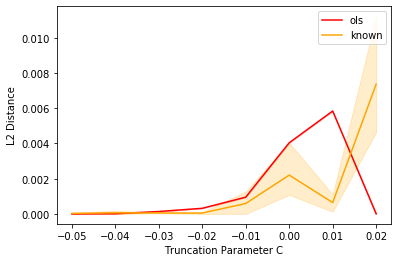

In [24]:
# plot results for regression parameter MSE
# sns.lineplot(data=results, x='c', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=results, x='c', y='ols_param_mse', label='ols', color='red')
ax = sns.lineplot(data=results, x='c', y='known_param_mse', label='known', color='orange')
ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance')
plt.show()

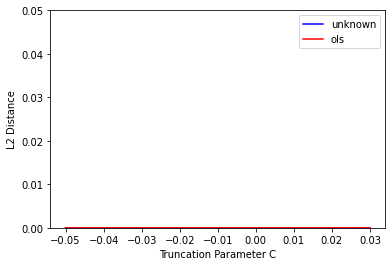

In [89]:
# plot results for regression noise variance MSE
sns.lineplot(data=results, x='c', y='unknown_var_l1', label='unknown', color="blue")
ax = sns.lineplot(data=results, x='c', y='ols_var_l1', label='ols', color="red")
ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance')
ax.set(ylim=(0, .05))
plt.show()